<a href="https://colab.research.google.com/github/SarthakNarayan/DL-and-ML/blob/master/googlecolab/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mouting Google drive

In [0]:
# mounting google drive for saving the weights
from google.colab import drive
drive.mount('/content/gdrive')

#Getting the data from kaggle

In [3]:
# importing the json file
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
# commands for loading kaggle dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# loading the bees and ants dataset from kaggle
!kaggle datasets download -d ajayrana/hymenoptera-data

 73% 33.0M/45.1M [00:01<00:00, 23.4MB/s]
100% 45.1M/45.1M [00:01<00:00, 42.2MB/s]


In [6]:
# Unzipping the data
!unzip "/content/hymenoptera-data.zip"

Archive:  /content/hymenoptera-data.zip
  inflating: hymenoptera_data.zip    


In [0]:
!unzip "/content/hymenoptera_data.zip"
# we have our data in a folder named as hymenoptera_data
# It has test and train data with ants and bees photos divided in the respective folders

#ETL Pipeline

In [8]:
# Loading the train and test data
import torch
import torchvision
from torchvision import transforms

# data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

trainset = torchvision.datasets.ImageFolder(root='/content/hymenoptera_data/train', 
                                            transform=data_transforms['train'])

testset = torchvision.datasets.ImageFolder(root='/content/hymenoptera_data/val', 
                                            transform=data_transforms['test'])

print("No of images in training set {}".format(len(trainset)))
print("No of images in test set {}".format(len(testset)))

No of images in training set 244
No of images in test set 153


In [9]:
# creating a validation set
trainset , validationset = torch.utils.data.random_split(trainset , [200,44])

# creating the data loaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=True)
validation_loader = torch.utils.data.DataLoader(validationset, batch_size=4,shuffle=True)

print("No of batches in train loader {}".format(len(train_loader)))
print("No of batches in test loader {}".format(len(test_loader)))
print("No of batches in validation loader {}".format(len(validation_loader)))

No of batches in train loader 50
No of batches in test loader 39
No of batches in validation loader 11


#Loading/Making the Model

In [0]:
# Since we are performing transfer learning we will load a model
from torchvision import models
# loading a resnet model with 18 layers
transfer_model = models.resnet18(pretrained=True)
print(transfer_model)
# on visualizing the layer we observe we have to replace the fc layer since we have only 2 classes

In [11]:
import torch.nn.functional as F
import torch.nn as nn

class ReplacementLayer(nn.Module):
    def __init__(self):
        super(ReplacementLayer , self).__init__()
        self.fc1 = nn.Linear(512 , 128)
        self.fc2 = nn.Linear(128 , 64)
        self.output = nn.Linear(64 , 2)
        
    def forward(self , x):
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.output(x)
        return x

end_layer = ReplacementLayer()
print("The last layers are :")
print(end_layer)

The last layers are :
ReplacementLayer(
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=2, bias=True)
)


In [0]:
# attaching our end_layer inplace of resnet fc layerer
transfer_model.fc = end_layer
# converting the model to make it cuda compatible
transfer_model = transfer_model.cuda()
print(transfer_model)

#Training Process

In [0]:
import torch.optim as optim
# loss function
criterion = nn.CrossEntropyLoss()
# defining the optimizer
# Since we want other layers to remain frozen and only update the weights of our fc layer
optimizer = optim.Adam(transfer_model.fc.parameters() , lr=1e-3)

num_epochs = 20
accuracy_max = 0
for i in range(num_epochs):
    
    running_train_loss = 0
    correct = 0
    accuracy = 0
    running_validation_loss = 0
    
    for images , labels in train_loader:
        # making images and labels cuda compatible
        images = images.cuda()
        labels = labels.cuda()
        
        # making the gradients zero
        optimizer.zero_grad()
        #forward pass
        logits = transfer_model(images)
        # calculating the loss
        loss = criterion(logits , labels)
        # backward propagation
        loss.backward()
        optimizer.step()
        running_train_loss += loss
    
    print("Training loss after epoch {}/{} is {} ".format(i+1 , num_epochs , running_train_loss/len(train_loader)))
    
    # putting the mode in evaluation mode
    transfer_model.eval()
    
    # Since we dont want to compute gradients 
    with torch.no_grad():
        for images_val , labels_val in validation_loader:
            images_val = images_val.cuda()
            labels_val = labels_val.cuda()
            
            prediction = transfer_model(images_val)
            values , indices = torch.max(prediction , 1)
            valid_loss = criterion(prediction , labels_val)
            
            running_validation_loss += valid_loss
            for j in range(len(indices)):
                if (indices[j] == labels_val[j]):
                    correct += 1
    
    accuracy = (correct/len(validationset))*100
    running_validation_loss = running_validation_loss/len(validation_loader)
    print("Validation loss and accuracy after epoch {}/{} is {} and {}".format(i+1 , 
                                                                               num_epochs , 
                                                                               running_validation_loss,
                                                                               accuracy))
    transfer_model.train()
    if accuracy_max < accuracy:
        accuracy_max = accuracy
        print("Maximum validation accuracy of {} at epoch {}/{}".format(accuracy_max,
                                                                    i+1 , 
                                                                    num_epochs))
        print("saving the model \n")
        torch.save(transfer_model.state_dict(), '/content/gdrive/My Drive/Colab Notebooks/TransferLearning.pth')
    else:
        print()

print("\n Training Over")

In [0]:
# loading the weights of the best model for testing
model_loaded = transfer_model
model_loaded.cuda()
model_loaded.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/TransferLearning.pth')) 
model_loaded.eval()

In [33]:
# testing the model
correct = 0
accuracy = 0
with torch.no_grad():
        for images_test , labels_test in test_loader:
            images_test = images_test.cuda()
            labels_test = labels_test.cuda()
            prediction = model_loaded(images_test)
            values , indices = torch.max(prediction , 1)
            test_loss = criterion(prediction , labels_test)
            
            for j in range(len(indices)):
                if (indices[j] == labels_test[j]):
                    correct += 1
    
accuracy = (correct/len(testset))*100
print("Test accuracy is {}".format(accuracy))

Test accuracy is 92.81045751633987


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


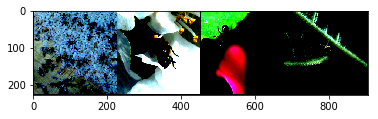

ants bees ants ants 

In [30]:
# visualizing test data
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def visualization(input_data):
    input_data = input_data.cpu()
    input_data = input_data.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * input_data + mean
    plt.imshow(input_data)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = ['ants' , 'bees']
# Make a grid from batch
images_test , images_label = next(iter(test_loader))
out = torchvision.utils.make_grid(images_test)

visualization(out)
for i in images_label:
    print(class_names[i] , end = " ")